In [1170]:
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from scipy.optimize import curve_fit
top_level=f'{os.getcwd()}/..'
from datetime import datetime
import glob
import re
import time
import struct
import pandas as pd
import seaborn as sns
from scipy.fft import fft,fftfreq
from scipy.signal import firwin, lfilter, freqz

In [2]:
def find_dat_file():
    file_list=[]
    def process_dat_file(dat_file_path):
        # ここに.datファイルに対する処理を記述する
        #print("Processing:", dat_file_path)
        file_list.append(dat_file_path)
        
    # ディレクトリのパス
    directory_path = "../datfile"

    # 指定した日付
    start_time = datetime(2024, 3, 6, 10, 30, 0)
    end_time = datetime(2024, 4, 16, 13, 0, 0)

    # ディレクトリ内のすべての.datファイルに対して処理を実行
    for dat_file in glob.glob(os.path.join(directory_path, "*.dat")):
        # ファイル名から日付部分を抽出
        match = re.search(r'data_(\d{8})_(\d{6})\.dat', dat_file)
        if match:
            file_datetime = datetime.strptime(match.group(1) + match.group(2), '%Y%m%d%H%M%S')
            # 指定した日付以降のファイルのみ処理する
            if file_datetime >= start_time and file_datetime <= end_time:
                process_dat_file(dat_file)
    return file_list


In [4]:
def datfile(filename):
    # Waveforms variables to be filled 
    ampFault = { i : []  for i in range(4) }  
    xPosFault = []
    yPosFault = []
    qBunchFault = []
    recordtime = []
    
    # Open the .dat file
    with fileio.FileReader(files='../datfile/'+filename) as fd:
        
        # Loop through the file data
        for header,data in fd.records():
    
            # Check if there is a 8-byte header in the frame
            if (header.flags==0):
                hdrOffset = 8
                hdr = struct.unpack("<d", data[:8])[0]
                timestamp = time.localtime(hdr)
                # Define the desired format string (replace with your preferred format)
                # Some common format specifiers:
                # %Y - Year with century
                # %m - Month as a decimal number (01-12)
                # %d - Day of the month as a decimal number (01-31)
                # %H - Hour in 24-hour format (00-23)
                # %M - Minute (00-59)
                # %S - Second (00-59)
                
                formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S', timestamp)
                #print( f'CH={header.channel}: Event Timestamp in human-readable format: {formatted_time}' )
                if header.channel==24:
                    recordtime.append(formatted_time)
            
            else:
                hdrOffset = 0
                print( 'No timestamp header detected' )
                return 0,0
            
            # Check for error in frame
            if (header.error>0):
                # Look at record header data
                print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
                print(f"Record size    = {header.size}")
                print(f"Record channel = {header.channel}")
                print(f"Record flags   = {header.flags:#x}")
                print(f"Record error   = {header.error:#x}")
    
            # Check if AMP Fault waveform
            elif (header.channel < 16) and (header.channel >= 12):
                ampFault[header.channel-12].append(data[hdrOffset:].view(np.int16))
    
            # Check if AMP Live waveform
            elif header.channel == 24:
                fpData = data[hdrOffset:].view(np.float32)
                fpDataLen = len(fpData)
                xPosFault.append(   fpData[0:(fpDataLen*3)+0:3] ) 
                yPosFault.append(   fpData[1:(fpDataLen*3)+1:3] )
                qBunchFault.append( fpData[2:(fpDataLen*3)+2:3] )
            
            # Else undefined stream index
            else:
                print( f'UNDEFINED DATA STREAM[{header.channel}]!!!')
    return ampFault, recordtime

# DV

In [70]:
def parse_and_plot(filename):
    ampFault, recordtime = datfile(filename)
    if recordtime==0:
        return
    if len(recordtime)==0:
        return
    #print(len(recordtime))
    for num in range(len(recordtime)):
        print(f'Selected time : {recordtime[num]}')
    
        def bunchindex(threshold,waveform):
            start=12800
            firstbunch=0
            for i in range(1,8*5120):
                if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                    if waveform[start+i]>threshold:
                        firstbunch=start+i
                        break
            if firstbunch==0:
                print("invalid data")
                return firstbunch, 0
        
            bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
            bunch_index=np.where(bunch_candidate>threshold)[0]
        
            return firstbunch, bunch_index
    
        firstbunch, bunch_index=bunchindex(1000,ampFault[0][num])
        if firstbunch==0:
            print("end process")
            continue
    
        #print(f'Downstream Num of bunch : {len(bunch_index)}')
        #print(f'Downstream First bunch index : {firstbunch}')
    
        if firstbunch>140000:
            continue
    
        start=12800
        y_pos=[]
        charge=[]
        for j in bunch_index:
            certain_bunch=[]
            certain_bunch_charge=[]
            for i in range(12):
                sum=ampFault[0][num][firstbunch+j*8+5120*8*i]
                delta=ampFault[1][num][firstbunch+j*8+5120*8*i]
                yposition=delta/sum*16.58/5+1.6
                certain_bunch.append(yposition)
                certain_bunch_charge.append(sum)
            y_pos.append(np.array(certain_bunch))
            charge.append(np.array(certain_bunch_charge))
        y_pos=np.array(y_pos)
        charge=np.array(charge)
    
        mean=np.mean(y_pos[:,0:2],axis=1)
        y_pos=y_pos-mean[:,np.newaxis]
        mean=np.mean(charge[:,0:2],axis=1)
        charge=charge/mean[:,np.newaxis]
        #print(y_pos)
        #print(charge)

        if np.std(np.array(y_pos)[:,0])>0.1:
            print("large std")
            continue
        if np.std(np.array(charge)[:,0])>0.005:
            print("charge large std")
            continue
        if np.min(np.concatenate(np.array(charge)))>0.95:
            print("no charge loss")
            continue
        if len(bunch_index)<700:
            print("the number of bunch is small")
            continue
        
        #make x axis
        bunch_index_12=[]
        for i in range(12):
            bunch_index_12.append(bunch_index+5120*i)

        x_axis=np.concatenate(bunch_index_12)/5120+1
            

        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(23,8))
        split=np.hsplit(y_pos,y_pos.shape[1])
        ax1.set_title(f'{recordtime[num]}')
        ax1.scatter(x_axis,np.concatenate(split),color='tomato',s=6)
        ax1.set_ylabel("Y position (mm)")
        ax1.set_ylim(-0.4,0.4)
        ax1.grid()
        ax1.text(0.03,0.05,'Downstream Vertical',transform=ax1.transAxes,ha='left',va='bottom',fontsize=20)

        split=np.hsplit(charge,charge.shape[1])
        ax2.scatter(x_axis,np.concatenate(split).reshape(len(x_axis)),color='royalblue',s=6)
        ax2.set_xlabel("Turn")
        ax2.set_ylabel("Charge")
        ax2.set_ylim(0,1.2)
        ax2.grid()
        ax2.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13],['0','0','1','2','3','4','5','6','7','8','9','10','abort'])
        ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
        ax2.set_xlim(3,13)
        ax2.text(0.03,0.05,'Downstream Charge',transform=ax2.transAxes,ha='left',va='bottom',fontsize=20)
        
        plt.subplots_adjust(hspace=.1)
        plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+filename[11:-4]+f'_{num}'+'.png',dpi=200,bbox_inches="tight",pad_inches=0.5)
        plt.close()
    #return np.array(y_pos),np.array(charge)

In [72]:
DV=find_dat_file()
for i in DV:
    parse_and_plot(i)
    

Selected time : 2024-04-14_04-59-21
charge large std
Selected time : 2024-04-16_10-16-55
invalid data
end process
Selected time : 2024-03-30_22-30-08
no charge loss
Selected time : 2024-04-16_11-16-40
invalid data
end process
Selected time : 2024-03-06_10-42-16
no charge loss
Selected time : 2024-03-06_14-25-22
invalid data
end process
Selected time : 2024-03-06_14-33-08
the number of bunch is small
Selected time : 2024-03-06_14-53-45
charge large std
Selected time : 2024-03-06_15-00-50
the number of bunch is small
Selected time : 2024-03-06_15-25-00
charge large std
Selected time : 2024-03-06_17-40-21
charge large std
Selected time : 2024-04-06_08-53-24
Selected time : 2024-03-30_17-53-53
Selected time : 2024-04-14_05-30-31
charge large std
Selected time : 2024-04-05_18-28-47
no charge loss
Selected time : 2024-04-11_18-37-25
no charge loss
Selected time : 2024-03-24_07-09-19
no charge loss
Selected time : 2024-04-13_03-13-40
Selected time : 2024-03-25_07-47-07
Selected time : 2024-04

/tmp/ipykernel_38036/415660957.py:59: RuntimeWarning: divide by zero encountered in divide
  charge=charge/mean[:,np.newaxis]
/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Selected time : 2024-04-10_13-53-53
charge large std
Selected time : 2024-04-10_13-55-07
charge large std
Selected time : 2024-04-10_13-57-38
charge large std
Selected time : 2024-04-10_13-58-35
charge large std
Selected time : 2024-04-10_13-59-26
charge large std
Selected time : 2024-04-10_14-00-20


/tmp/ipykernel_38036/415660957.py:59: RuntimeWarning: divide by zero encountered in divide
  charge=charge/mean[:,np.newaxis]
/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Selected time : 2024-04-10_14-01-26
charge large std
Selected time : 2024-04-09_05-57-38
Selected time : 2024-04-16_11-35-22
invalid data
end process
Selected time : 2024-04-06_18-33-49
no charge loss
Selected time : 2024-04-01_04-36-13
no charge loss
Selected time : 2024-04-12_15-05-30
charge large std
Selected time : 2024-04-16_13-17-46
no charge loss
Selected time : 2024-03-18_20-43-24
charge large std
Selected time : 2024-04-12_19-58-16
Selected time : 2024-04-16_11-21-14
invalid data
end process
Selected time : 2024-03-25_06-38-26
no charge loss
Selected time : 2024-04-12_21-48-32
Selected time : 2024-04-13_06-25-16
invalid data
end process
Selected time : 2024-04-14_14-15-46
invalid data
end process
Selected time : 2024-04-12_11-07-36
invalid data
end process
Selected time : 2024-04-11_16-32-50
invalid data
end process
Selected time : 2024-04-16_10-37-12
invalid data
end process
Selected time : 2024-04-13_00-44-57
charge large std
Selected time : 2024-04-12_06-24-35
no charge los

# some weired plots are deleted here and move to UV

In [133]:
def find_png_file():
    file_list=[]
    num_list=[]
    def process_dat_file(dat_file_path,num):
        # ここに.datファイルに対する処理を記述する
        #print("Processing:", dat_file_path)
        file_list.append(dat_file_path)
        num_list.append(num)
        
    # ディレクトリのパス
    directory_path = "../../../../work/ipac_analysis/DV/"

    # 指定した日付
    start_time = datetime(2024, 3, 2, 10, 30, 0)
    end_time = datetime(2024, 4, 20, 13, 0, 0)

    # ディレクトリ内のすべての.datファイルに対して処理を実行
    for dat_file in glob.glob(os.path.join(directory_path, "*.png")):
        # ファイル名から日付部分を抽出
        match = re.search(r'data_(\d{8})_(\d{6})_(\d+)\.png', dat_file)
        if match:
            file_datetime = datetime.strptime(match.group(1) + match.group(2), '%Y%m%d%H%M%S')
            num=int(match.group(3))
            # 指定した日付以降のファイルのみ処理する
            if file_datetime >= start_time and file_datetime <= end_time:
                process_dat_file(dat_file[34:-6],num)
    return file_list, num_list

In [134]:
DV_filename=find_png_file()[0]
DV_file_num=find_png_file()[1]
print(len(DV_filename))
print(len(DV_file_num))
print(DV_filename)

65
65
['data_20240323_091420', 'data_20240405_182849', 'data_20240401_221706', 'data_20240413_005829', 'data_20240309_115540', 'data_20240327_190358', 'data_20240405_024853', 'data_20240322_200311', 'data_20240406_104928', 'data_20240402_054532', 'data_20240416_000609', 'data_20240331_160053', 'data_20240307_191034', 'data_20240330_010639', 'data_20240414_024721', 'data_20240412_201042', 'data_20240411_023343', 'data_20240328_052654', 'data_20240328_190230', 'data_20240409_041622', 'data_20240322_234317', 'data_20240411_183727', 'data_20240405_233122', 'data_20240323_171747', 'data_20240324_194847', 'data_20240322_033232', 'data_20240325_180554', 'data_20240411_231200', 'data_20240331_080708', 'data_20240323_070827', 'data_20240414_211104', 'data_20240412_215932', 'data_20240324_204715', 'data_20240321_221813', 'data_20240413_180833', 'data_20240412_190229', 'data_20240402_192213', 'data_20240330_153919', 'data_20240406_085328', 'data_20240414_075533', 'data_20240415_090346', 'data_202

In [135]:
UV_filename=[]
UV_file_num=[]
for j in range(len(DV_filename)):

    # 元の文字列
    date_string = DV_filename[j]
    
    # 年、月、日、時、分、秒の情報を抽出
    year = int(date_string[5:9])
    month = int(date_string[9:11])
    day = int(date_string[11:13])
    hour = int(date_string[14:16])
    minute = int(date_string[16:18])
    second = int(date_string[18:20])
    
    # 解析した日時を作成
    parsed_date = datetime(year, month, day, hour, minute, second)
    
    # 比較対象の日時を指定
    comparison_date = datetime(2024, 4, 2, 19, 22, 0) 
    
    # 解析した日時が比較対象の日時より後の場合にのみ、処理を実行
    if parsed_date >= comparison_date:
        UV_filename.append(DV_filename[j])
        UV_file_num.append(DV_file_num[j])

In [136]:
print(len(UV_filename))
print(len(UV_file_num))

30
30


In [137]:
DV_filename[0]

'data_20240323_091420'

# move to analysis

In [719]:
def parse_and_plot_2(filename,num):
    ampFault, recordtime = datfile(filename+'.dat')
    if recordtime==0:
        return
    if len(recordtime)==0:
        return
    #print(len(recordtime))
    #print(f'Selected time : {recordtime[num]}')

    def bunchindex(threshold,waveform):
        start=12800
        firstbunch=0
        for i in range(1,8*5120):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
        if firstbunch==0:
            print("invalid data")
            return firstbunch, 0
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(1000,ampFault[0][num])
    if firstbunch==0:
        print("end process")
        return

    #print(f'Downstream Num of bunch : {len(bunch_index)}')
    #print(f'Downstream First bunch index : {firstbunch}')

    if firstbunch>140000:
        return

    start=12800
    y_pos=[]
    charge=[]
    for j in bunch_index:
        certain_bunch=[]
        certain_bunch_charge=[]
        for i in range(12):
            sum=ampFault[0][num][firstbunch+j*8+5120*8*i]
            delta=ampFault[1][num][firstbunch+j*8+5120*8*i]
            yposition=delta/sum*16.58/5+1.6
            certain_bunch.append(yposition)
            certain_bunch_charge.append(sum)
        y_pos.append(np.array(certain_bunch))
        charge.append(np.array(certain_bunch_charge))
    y_pos=np.array(y_pos)
    charge=np.array(charge)

    mean=np.mean(y_pos[:,0:2],axis=1)
    y_pos=y_pos-mean[:,np.newaxis]
    mean=np.mean(charge[:,0:2],axis=1)
    charge=charge/mean[:,np.newaxis]
    #print(y_pos[:,-3:])
    #print(charge)
    y_first_turn=np.concatenate(y_pos[:,2:5])
    y_last_turn=np.concatenate(y_pos[:,-3:])
    loss=1-np.min(np.concatenate(charge))

    std=np.std(y_last_turn)/np.std(y_first_turn)
    minmax=(np.max(y_last_turn)-np.min(y_last_turn))/(np.max(y_first_turn)-np.min(y_first_turn))#
    return std, minmax, loss, np.array(y_pos)

In [720]:
def parse_and_plot_UV(filename,num):
    ampFault, recordtime = datfile(filename+'.dat')
    if recordtime==0:
        return
    if len(recordtime)==0:
        return
    #print(len(recordtime))
    #print(f'Selected time : {recordtime[num]}')

    def bunchindex(threshold,waveform):
        start=12800
        firstbunch=0
        for i in range(1,8*5120):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
        if firstbunch==0:
            print("invalid data")
            return firstbunch, 0
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(1700,ampFault[2][num])
    if firstbunch==0:
        print("end process")
        return

    #print(f'Downstream Num of bunch : {len(bunch_index)}')
    #print(f'Downstream First bunch index : {firstbunch}')

    if firstbunch>140000:
        return

    start=12800
    y_pos=[]
    charge=[]
    for j in bunch_index:
        certain_bunch=[]
        certain_bunch_charge=[]
        for i in range(12):
            sum=ampFault[2][num][firstbunch+j*8+5120*8*i]
            delta=ampFault[3][num][firstbunch+j*8+5120*8*i]
            yposition=delta/sum*16.58/5+1.6
            certain_bunch.append(yposition)
            certain_bunch_charge.append(sum)
        y_pos.append(np.array(certain_bunch))
        charge.append(np.array(certain_bunch_charge))
    y_pos=np.array(y_pos)
    charge=np.array(charge)

    mean=np.mean(y_pos[:,0:2],axis=1)
    y_pos=y_pos-mean[:,np.newaxis]
    mean=np.mean(charge[:,0:2],axis=1)
    charge=charge/mean[:,np.newaxis]
    #print(y_pos[:,-3:])
    #print(charge)
    y_first_turn=np.concatenate(y_pos[:,2:5])
    y_last_turn=np.concatenate(y_pos[:,-3:])
    loss=1-np.min(np.concatenate(charge))
    std=np.std(y_last_turn)/np.std(y_first_turn)
    minmax=(np.max(y_last_turn)-np.min(y_last_turn))/(np.max(y_first_turn)-np.min(y_first_turn))#
    return std, minmax, loss, np.array(y_pos)

In [721]:
std_DV=[]
minmax_DV=[]
loss_DV=[]
diff_DV=[]
print(len(DV_filename))
for i in range(len(DV_filename)):
    std_DV.append(parse_and_plot_2(DV_filename[i],DV_file_num[i])[0])
    minmax_DV.append(parse_and_plot_2(DV_filename[i],DV_file_num[i])[1])
    loss_DV.append(parse_and_plot_2(DV_filename[i],DV_file_num[i])[2])
    #diff_DV.append(parse_and_plot_2(DV_filename[i],DV_file_num[i])[0]-parse_and_plot_UV(DV_filename[i],DV_file_num[i])[0])

65


In [722]:
data_DV=pd.DataFrame({'std_ratio':std_DV,"minmax_ratio":minmax_DV,'loss':loss_DV})

<Axes: xlabel='std_ratio', ylabel='Count'>

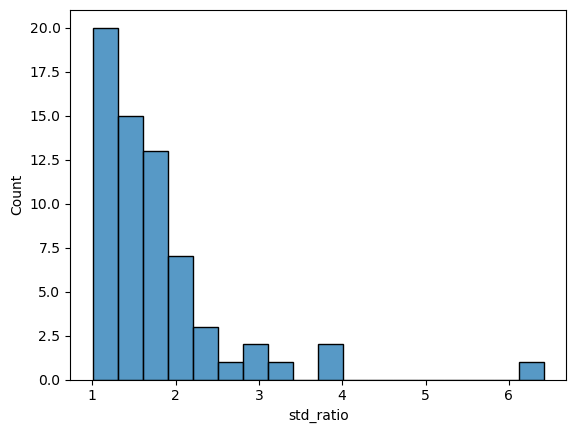

In [723]:
sns.histplot(data_DV["std_ratio"],bins=18)

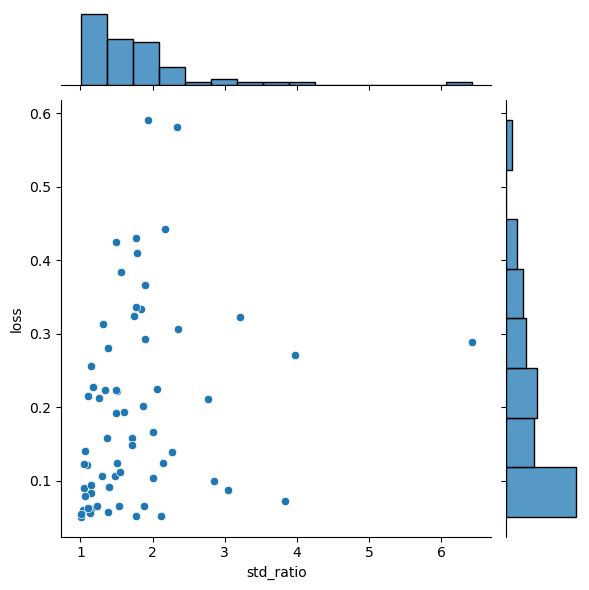

In [726]:
sns.jointplot(data=data_DV,x='std_ratio',y='loss')

In [730]:
std_DV=[]
minmax_DV=[]
loss_DV=[]
std_UV=[]
minmax_UV=[]
loss_UV=[]
diff_std=[]
diff_minmax=[]

print(len(UV_filename))
for i in range(len(UV_filename)):
    name=UV_filename[i]
    num=UV_file_num[i]
    std_DV.append(parse_and_plot_2(name,num)[0])
    minmax_DV.append(parse_and_plot_2(name,num)[1])
    loss_DV.append(parse_and_plot_2(name,num)[2])
    std_UV.append(parse_and_plot_UV(name,num)[0])
    minmax_UV.append(parse_and_plot_UV(name,num)[1])
    loss_UV.append(parse_and_plot_UV(name,num)[2])
    diff_std.append(parse_and_plot_2(name,num)[0]-parse_and_plot_UV(name,num)[0])
    diff_minmax.append(parse_and_plot_2(name,num)[1]-parse_and_plot_UV(name,num)[1])

30


In [863]:
hue_array_UV=["Upstream"]*len(loss_UV)
hue_array_DV=["Downstream"]*len(loss_DV)
df_UV=pd.DataFrame({'std_ratio':std,"minmax_ratio":minmax,'loss':loss,'D or U':hue_array_UV})
df_DV=pd.DataFrame({'std_ratio':std_DV,"minmax_ratio":minmax_DV,'loss':loss_DV,'D or U':hue_array_DV})
data_both=pd.concat([df_UV,df_DV],axis=0)
data_diff=pd.DataFrame({"std_ratio diff":diff_std, "minmax_ratio diff":diff_minmax})

<Axes: xlabel='std_ratio diff', ylabel='Count'>

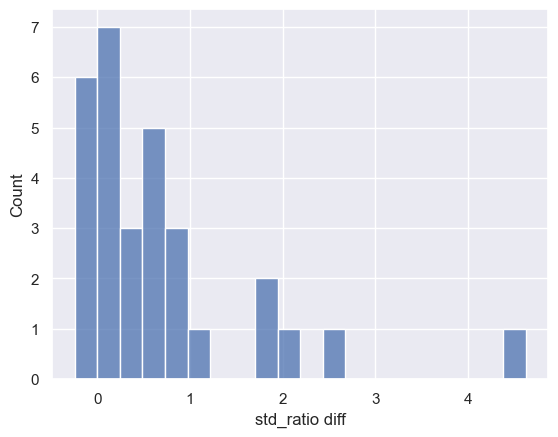

In [848]:
sns.histplot(data_diff["std_ratio diff"],bins=20)

<Axes: xlabel='minmax_ratio', ylabel='Count'>

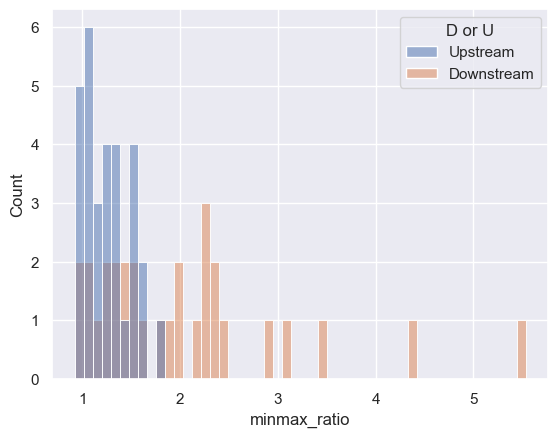

In [864]:
sns.histplot(data_both,x='minmax_ratio',hue='D or U',bins=50)

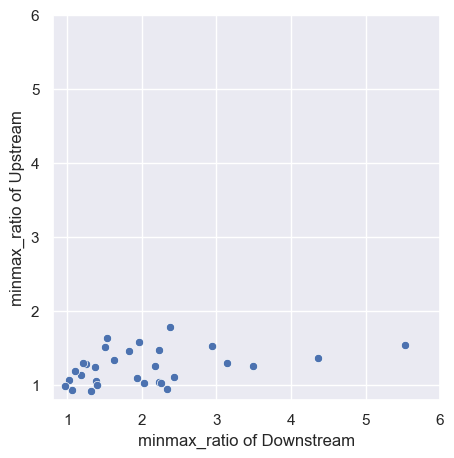

In [867]:
sns.set()
plt.figure(figsize=(5,5))
sns.scatterplot(x=data_both.loc[data_both['D or U']=='Downstream','minmax_ratio'],y=data_both.loc[data_both['D or U']=='Upstream','minmax_ratio'])
plt.xlabel("minmax_ratio of Downstream")
plt.ylabel("minmax_ratio of Upstream")
plt.xlim(0.8,6)
plt.ylim(0.8,6)
plt.show()

# FFT

In [695]:
for number in range(len(DV_filename)):
    print(DV_filename[number])
    last_turn=np.concatenate([parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-3],
                            parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-2],
                            parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-1]])

    #fft_result = fft(last_turn)
    fft_result = np.fft.fft(last_turn)
    
    # パワースペクトル（振幅）を計算
    power_spectrum = np.abs(fft_result)
    
    # 周波数軸を生成
    sampling_frequency = 1  # サンプリング周波数
    frequency_axis = fftfreq(len(last_turn), d=1/sampling_frequency)
    
    # プロット
    plt.figure(figsize=(8, 6))
    plt.plot(frequency_axis, power_spectrum)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('FFT Result')
    plt.grid(True)
    plt.xscale('log')
    plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_fft'+'.png',dpi=200)
    plt.close()

for number in range(len(UV_filename)):
    print(UV_filename[number])
    last_turn=np.concatenate([parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-3],
                            parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-2],
                            parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-1]])

    #fft_result = fft(last_turn)
    fft_result = np.fft.fft(last_turn)
    
    # パワースペクトル（振幅）を計算
    power_spectrum = np.abs(fft_result)
    
    # 周波数軸を生成
    sampling_frequency = 1  # サンプリング周波数
    frequency_axis = fftfreq(len(last_turn), d=1/sampling_frequency)
    
    # プロット
    plt.figure(figsize=(8, 6))
    plt.plot(frequency_axis, power_spectrum)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('FFT Result')
    plt.grid(True)
    plt.xscale('log')
    plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_fft'+'.png',dpi=200)
    plt.close()

data_20240323_091420
data_20240405_182849
data_20240401_221706
data_20240413_005829
data_20240309_115540
data_20240327_190358
data_20240405_024853
data_20240322_200311
data_20240406_104928
data_20240402_054532
data_20240416_000609
data_20240331_160053
data_20240307_191034
data_20240330_010639
data_20240414_024721
data_20240412_201042
data_20240411_023343
data_20240328_052654
data_20240328_190230
data_20240409_041622
data_20240322_234317
data_20240411_183727
data_20240405_233122
data_20240323_171747
data_20240324_194847
data_20240322_033232
data_20240325_180554
data_20240411_231200
data_20240331_080708
data_20240323_070827
data_20240414_211104
data_20240412_215932
data_20240324_204715
data_20240321_221813
data_20240413_180833
data_20240412_190229
data_20240402_192213
data_20240330_153919
data_20240406_085328
data_20240414_075533
data_20240415_090346
data_20240405_112729
data_20240325_070032
data_20240322_220131
data_20240414_053323
data_20240326_214035
data_20240325_121601
data_20240406

# MA

In [696]:
def parse_and_plot_MA_UV(filename,num):
    ampFault, recordtime = datfile(filename+'.dat')
    if recordtime==0:
        return
    if len(recordtime)==0:
        return
    #print(len(recordtime))
    #print(f'Selected time : {recordtime[num]}')

    def bunchindex(threshold,waveform):
        start=12800
        firstbunch=0
        for i in range(1,8*5120):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
        if firstbunch==0:
            print("invalid data")
            return firstbunch, 0
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(1700,ampFault[2][num])
    if firstbunch==0:
        print(f"end process: UV{filename}_{num}")
        return

    #print(f'Downstream Num of bunch : {len(bunch_index)}')
    #print(f'Downstream First bunch index : {firstbunch}')

    if firstbunch>140000:
        return

    start=12800
    y_pos=[]
    charge=[]
    for j in bunch_index:
        certain_bunch=[]
        certain_bunch_charge=[]
        for i in range(12):
            sum=ampFault[2][num][firstbunch+j*8+5120*8*i]
            delta=ampFault[3][num][firstbunch+j*8+5120*8*i]
            yposition=delta/sum*16.58/5+1.6
            certain_bunch.append(yposition)
            certain_bunch_charge.append(sum)
        y_pos.append(np.array(certain_bunch))
        charge.append(np.array(certain_bunch_charge))
    y_pos=np.array(y_pos)
    charge=np.array(charge)

    mean=np.mean(y_pos[:,0:2],axis=1)
    y_pos=y_pos-mean[:,np.newaxis]
    mean=np.mean(charge[:,0:2],axis=1)
    charge=charge/mean[:,np.newaxis]
    #print(y_pos[:,-3:])
    #print(charge)
    y_first_turn=np.concatenate(y_pos[:,3:5])
    y_last_turn=np.concatenate(y_pos[:,-3:])
    loss=1-np.min(np.concatenate(charge))
    
    #make x axis
    bunch_index_12=[]
    for i in range(12):
        bunch_index_12.append(bunch_index+5120*i)

    x_axis=np.concatenate(bunch_index_12)/5120+1
        
    split=np.hsplit(y_pos,y_pos.shape[1])
    pos=np.concatenate(split).flatten()
    data=pd.DataFrame({"x_axis":x_axis,"UV":pos})
    data["MA"]=data["UV"].rolling(window=500).mean()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(23,8))
    ax1.set_title(f'{recordtime[num]}')
    ax1.scatter(data["x_axis"],data["UV"],color="tomato",s=5)
    ax1.plot(data["x_axis"],data["MA"],color='tab:green')
    ax1.set_ylabel("Y position (mm)")
    ax1.set_ylim(-0.4,0.4)
    ax1.grid()
    ax1.text(0.03,0.05,'Upstream Vertical',transform=ax1.transAxes,ha='left',va='bottom',fontsize=20)

    split=np.hsplit(charge,charge.shape[1])
    ax2.scatter(x_axis,np.concatenate(split),color='royalblue',s=6)
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Charge")
    ax2.set_ylim(0,1.2)
    ax2.grid()
    ax2.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13],['0','0','1','2','3','4','5','6','7','8','9','10','abort'])
    ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax2.set_xlim(3,13)
    ax2.text(0.03,0.05,'Upstream Charge',transform=ax2.transAxes,ha='left',va='bottom',fontsize=20)
    
    plt.subplots_adjust(hspace=.1)
    plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+filename[5:]+f'_{num}'+'.png',dpi=200,bbox_inches="tight",pad_inches=0.5)
    plt.close()
    print("succeed")
    
    return np.std(y_last_turn)/np.std(y_first_turn), (np.max(y_last_turn)-np.min(y_last_turn))/(np.max(y_first_turn)-np.min(y_first_turn)), loss



In [697]:
def parse_and_plot_MA_DV(filename,num):
    ampFault, recordtime = datfile(filename+'.dat')
    if recordtime==0:
        return
    if len(recordtime)==0:
        return
    #print(len(recordtime))
    #print(f'Selected time : {recordtime[num]}')

    def bunchindex(threshold,waveform):
        start=12800
        firstbunch=0
        for i in range(1,8*5120):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
        if firstbunch==0:
            print("invalid data")
            return firstbunch, 0
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(1000,ampFault[0][num])
    if firstbunch==0:
        print(f"end process: DV{filename}_{num}")
        return

    #print(f'Downstream Num of bunch : {len(bunch_index)}')
    #print(f'Downstream First bunch index : {firstbunch}')

    if firstbunch>140000:
        return

    start=12800
    y_pos=[]
    charge=[]
    for j in bunch_index:
        certain_bunch=[]
        certain_bunch_charge=[]
        for i in range(12):
            sum=ampFault[0][num][firstbunch+j*8+5120*8*i]
            delta=ampFault[1][num][firstbunch+j*8+5120*8*i]
            yposition=delta/sum*16.58/5+1.6
            certain_bunch.append(yposition)
            certain_bunch_charge.append(sum)
        y_pos.append(np.array(certain_bunch))
        charge.append(np.array(certain_bunch_charge))
    y_pos=np.array(y_pos)
    charge=np.array(charge)

    mean=np.mean(y_pos[:,0:2],axis=1)
    y_pos=y_pos-mean[:,np.newaxis]
    mean=np.mean(charge[:,0:2],axis=1)
    charge=charge/mean[:,np.newaxis]
    #print(y_pos[:,-3:])
    #print(charge)
    y_first_turn=np.concatenate(y_pos[:,3:5])
    y_last_turn=np.concatenate(y_pos[:,-3:])
    loss=1-np.min(np.concatenate(charge))
    
    #make x axis
    bunch_index_12=[]
    for i in range(12):
        bunch_index_12.append(bunch_index+5120*i)

    x_axis=np.concatenate(bunch_index_12)/5120+1
        
    split=np.hsplit(y_pos,y_pos.shape[1])
    pos=np.concatenate(split).flatten()
    data=pd.DataFrame({"x_axis":x_axis,"UV":pos})
    data["MA"]=data["UV"].rolling(window=500).mean()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(23,8))
    ax1.set_title(f'{recordtime[num]}')
    ax1.scatter(data["x_axis"],data["UV"],color="red",s=5)
    ax1.plot(data["x_axis"],data["MA"],color='tab:green')
    ax1.set_ylabel("Y position (mm)")
    ax1.set_ylim(-0.4,0.4)
    ax1.grid()
    ax1.text(0.03,0.05,'Downstream Vertical',transform=ax1.transAxes,ha='left',va='bottom',fontsize=20)

    split=np.hsplit(charge,charge.shape[1])
    ax2.scatter(x_axis,np.concatenate(split),color='blue',s=6)
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Charge")
    ax2.set_ylim(0,1.2)
    ax2.grid()
    ax2.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13],['0','0','1','2','3','4','5','6','7','8','9','10','abort'])
    ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax2.set_xlim(3,13)
    ax2.text(0.03,0.05,'Downstream Charge',transform=ax2.transAxes,ha='left',va='bottom',fontsize=20)
    
    plt.subplots_adjust(hspace=.1)
    plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+filename[5:]+f'_{num}'+'.png',dpi=200,bbox_inches="tight",pad_inches=0.5)
    plt.close()
    print('succeed')
    
    return np.std(y_last_turn)/np.std(y_first_turn), (np.max(y_last_turn)-np.min(y_last_turn))/(np.max(y_first_turn)-np.min(y_first_turn)), loss

In [698]:
for i in range(len(UV_filename)):
    print(i)
    parse_and_plot_MA_UV(UV_filename[i],UV_file_num[i])

for i in range(len(DV_filename)):
    print(i)
    parse_and_plot_MA_DV(DV_filename[i],DV_file_num[i])


0
succeed
1
succeed
2
succeed
3
succeed
4
succeed
5
succeed
6
succeed
7
succeed
8
succeed
9
succeed
10
succeed
11
succeed
12
succeed
13
succeed
14
succeed
15
succeed
16
succeed
17
succeed
18
succeed
19
succeed
20
succeed
21
succeed
22
succeed
23
succeed
24
succeed
25
succeed
26
succeed
27
succeed
28
succeed
29
succeed
0
succeed
1
succeed
2
succeed
3
succeed
4
succeed
5
succeed
6
succeed
7
succeed
8
succeed
9
succeed
10
succeed
11
succeed
12
succeed
13
succeed
14
succeed
15
succeed
16
succeed
17
succeed
18
succeed
19
succeed
20
succeed
21
succeed
22
succeed
23
succeed
24
succeed
25
succeed
26
succeed
27
succeed
28
succeed
29
succeed
30
succeed
31
succeed
32
succeed
33
succeed
34
succeed
35
succeed
36
succeed
37
succeed
38
succeed
39
succeed
40
succeed
41
succeed
42
succeed
43
succeed
44
succeed
45
succeed
46
succeed
47
succeed
48
succeed
49
succeed
50
succeed
51
succeed
52
succeed
53
succeed
54
succeed
55
succeed
56
succeed
57
succeed
58
succeed
59
succeed
60
succeed
61
succeed
62
succe

# Correlation

In [1078]:
sns.set()
peak_DV=[]
peak_UV=[]
for number in range(len(UV_filename)):
    print(DV_filename[number])
    last_turn=np.concatenate([parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-3],
                            parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-2],
                            parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-1]])

    x,y,_,__=plt.acorr(last_turn,maxlags=len(last_turn)-1)

    data=pd.DataFrame({"x":x,"y":y})
    data["MA"]=data["y"].rolling(window=200).mean()

    # 極大値と極小値を見つける
    peaks_max, _ = find_peaks(data["MA"], prominence=0.01)  # prominenceはピークの高さのしきい値
    peaks_min, _ = find_peaks(-1*data["MA"], prominence=0.01) # yを反転して極小値を見つけます
    peak_DV.append(len(peaks_max)+len(peaks_min))
    # プロット
    plt.plot(x[peaks_max], data["MA"][peaks_max] ,'ro', label='Max peaks',markersize=10) # 極大値を赤でプロット
    plt.plot(x[peaks_min], data["MA"][peaks_min],'go', label='Min peaks',markersize=10) # 極小値を緑でプロット

    plt.scatter(x, y, label='Data',s=4)
    plt.plot(x, data['MA'], color='red')
    plt.legend()
    plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)
    plt.close()

for number in range(len(UV_filename)):
    print(UV_filename[number])
    last_turn=np.concatenate([parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-3],
                            parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-2],
                            parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-1]])

    x,y,_,__=plt.acorr(last_turn,maxlags=len(last_turn)-1)
    data=pd.DataFrame({"x":x,"y":y})
    data["MA"]=data["y"].rolling(window=200).mean()

    # 極大値と極小値を見つける
    peaks_max, _ = find_peaks(data["MA"], prominence=0.01)  # prominenceはピークの高さのしきい値
    peaks_min, _ = find_peaks(-1*data["MA"], prominence=0.01) # yを反転して極小値を見つけます
    peak_UV.append(len(peaks_max)+len(peaks_min))
    # プロット
    plt.plot(x[peaks_max], data["MA"][peaks_max],'ro', label='Max peaks',markersize=10) # 極大値を赤でプロット
    plt.plot(x[peaks_min], data["MA"][peaks_min],'go', label='Min peaks',markersize=10) # 極小値を緑でプロット
    
    plt.scatter(x, y, label='Data',s=4)
    plt.plot(x, data['MA'], color='red')
    plt.legend()
    plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)
    plt.close()

data_20240323_091420


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240405_182849


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240401_221706


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240413_005829


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240309_115540


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240327_190358


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240405_024853


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240322_200311


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240406_104928


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240402_054532


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240416_000609


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240331_160053


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)
/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240307_191034
data_20240330_010639


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240414_024721


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240412_201042


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240411_023343


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240328_052654


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240328_190230


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240409_041622


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240322_234317


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240411_183727


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240405_233122


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240323_171747


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240324_194847


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240322_033232


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240325_180554


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240411_231200


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240331_080708


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240323_070827


/tmp/ipykernel_38036/1846524890.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+f'{DV_filename[number][5:]}'+f'_{DV_file_num[number]}_corr'+'.png',dpi=200)


data_20240405_182849


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240413_005829


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240405_024853


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240406_104928


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240416_000609


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240414_024721


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240412_201042


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240411_023343


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240409_041622


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240411_183727


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240405_233122


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240411_231200


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240414_211104


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240412_215932


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240413_180833


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240412_190229


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240402_192213


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240406_085328


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240414_075533


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240415_090346


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240405_112729


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240414_053323


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240406_220945


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240412_182846


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240414_180023


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240406_064757


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240404_054128


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240412_175016


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240405_193102


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


data_20240405_205858


/tmp/ipykernel_38036/1846524890.py:50: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+f'{UV_filename[number][5:]}'+f'_{UV_file_num[number]}_corr'+'.png',dpi=200)


In [ ]:
#DV only 65
data_DV["num_of_peak"]=peak_DV

<Axes: xlabel='num_of_peak', ylabel='Count'>

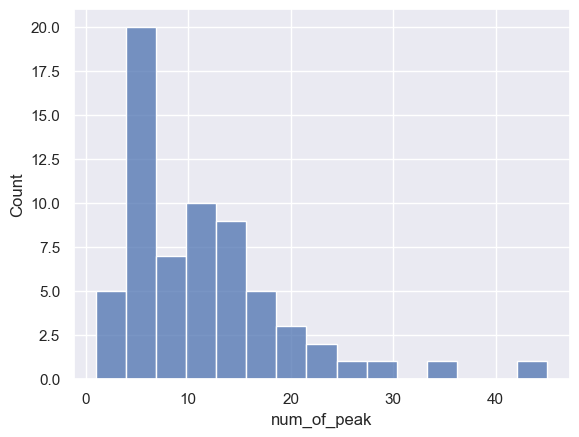

In [983]:
sns.histplot(data_DV["num_of_peak"],bins=15)

<Axes: xlabel='num_of_peak', ylabel='loss'>

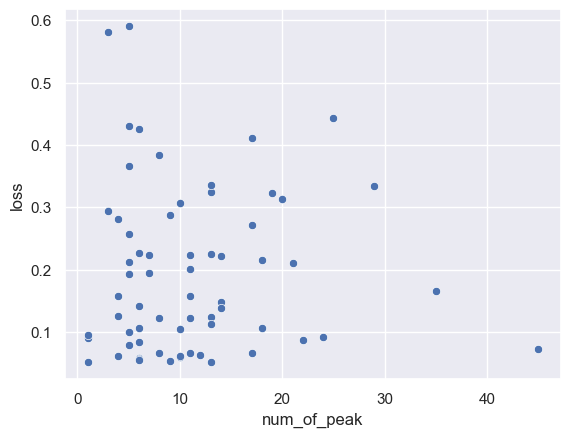

In [844]:
sns.scatterplot(x=data_DV["num_of_peak"],y=data_DV["loss"])

In [976]:
# DV and UV 30
data_both['num_of_peak']=np.concatenate([peak_UV,peak_DV])

In [977]:
data_both

,std_ratio,minmax_ratio,loss,D or U,num_of_peak
0,1.464804,1.464877,0.446746,Upstream,5
1,1.456551,1.365185,0.271092,Upstream,13
2,1.347000,1.244487,0.213062,Upstream,6
3,1.382853,1.631163,0.098039,Upstream,44
4,1.282876,1.280294,0.203170,Upstream,13
5,1.353909,1.062488,0.223206,Upstream,6
6,1.228473,1.114164,0.130537,Upstream,5
7,1.033972,0.998391,0.066980,Upstream,6
8,1.725373,1.522032,0.121445,Upstream,9
9,1.111971,1.255306,0.380363,Upstream,5


<Axes: xlabel='num_of_peak', ylabel='Count'>

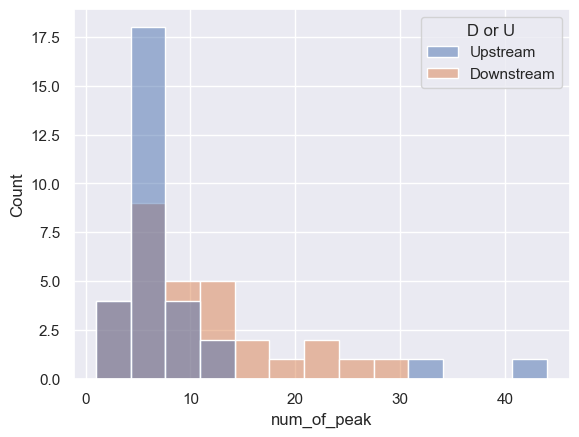

In [978]:
sns.histplot(data_both,x='num_of_peak',hue='D or U',bins=13)

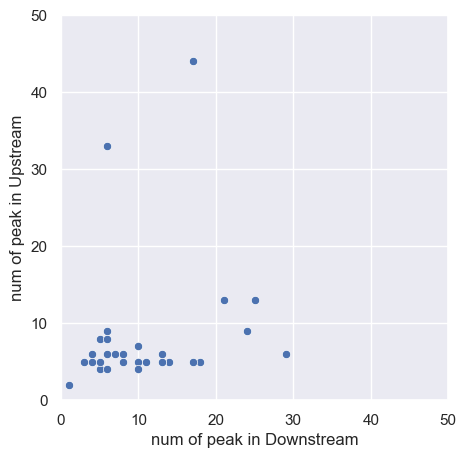

In [979]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=data_both.loc[data_both['D or U']=='Downstream','num_of_peak'],y=data_both.loc[data_both['D or U']=='Upstream','num_of_peak'])
plt.xlabel("num of peak in Downstream")
plt.ylabel("num of peak in Upstream")
plt.xlim(0,50)
plt.ylim(0,50)
plt.show()

In [980]:
data_both

,std_ratio,minmax_ratio,loss,D or U,num_of_peak
0,1.464804,1.464877,0.446746,Upstream,5
1,1.456551,1.365185,0.271092,Upstream,13
2,1.347000,1.244487,0.213062,Upstream,6
3,1.382853,1.631163,0.098039,Upstream,44
4,1.282876,1.280294,0.203170,Upstream,13
5,1.353909,1.062488,0.223206,Upstream,6
6,1.228473,1.114164,0.130537,Upstream,5
7,1.033972,0.998391,0.066980,Upstream,6
8,1.725373,1.522032,0.121445,Upstream,9
9,1.111971,1.255306,0.380363,Upstream,5


(array([-7037, -7036, -7035, ...,  7035,  7036,  7037]),
 array([-2.87899601e-04, -4.71457386e-04, -3.98380468e-04, ...,
        -2.58540257e-04, -1.20761812e-05,  9.47978260e-05]),
 <matplotlib.lines.Line2D at 0x7f6a6bea0b80>)

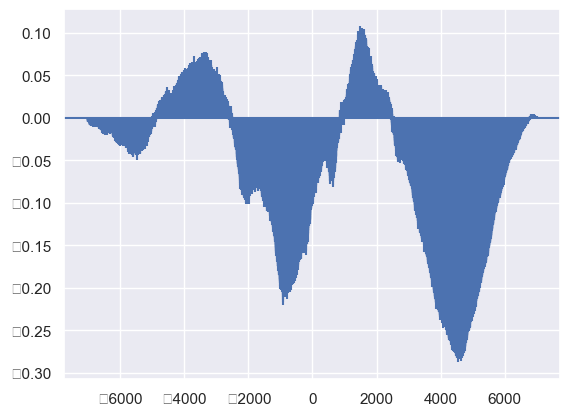

In [995]:
number=6
last_turn_UV=np.concatenate([parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-3],
                            parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-2],
                            parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-1]])

last_turn_DV=np.concatenate([parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-3],
                            parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-2],
                            parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-1]])

plt.xcorr(last_turn_UV,last_turn_DV,maxlags=len(last_turn_DV)-1)

#

data_20240323_091420
[ 95 104]
data_20240405_182849
[  94  965 1946 3695 4663 5450 6615]
data_20240401_221706
[ 87 112]
data_20240413_005829
[  99 1584 2285 3860 5930]
data_20240309_115540
[  99 1329 1876 2489 3037 4337]
data_20240327_190358
[  99  948 1858 2966 3616 4716 5454 6586]
data_20240405_024853
[  97  102 1333 2884 5411]
data_20240322_200311
[  94  105 6147]
data_20240406_104928
[  98  101  557 2734 3537 4931 6242]
data_20240402_054532
[  93  106 1872 3746]
data_20240416_000609
[ 105 3623]
data_20240331_160053
data_20240307_191034
[  99 1011]
data_20240330_010639
[  99 1618 3272 6497]
data_20240414_024721
[ 109 4121]
data_20240412_201042
[  99 1097 2876 5473]
data_20240411_023343
[  88  111 4780]
data_20240328_052654
[  96  103 1064 1799 2983 4694]
data_20240328_190230
[  97  102 5440 6681]
data_20240409_041622
[  94  105 5313]
data_20240322_234317
[  99 4727 5781]
data_20240411_183727
[  98  101 3323]
data_20240405_233122
data_20240323_171747
[  97  102 4972]
data_20240324_19

/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


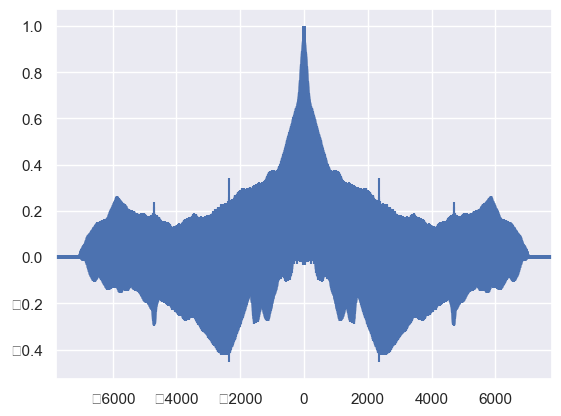

In [1091]:
height_DV=[]
height_UV=[]
lag_DV=[]
lag_UV=[]
for number in range(len(DV_filename)):
    print(DV_filename[number])
    last_turn=np.concatenate([parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-3],
                            parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-2],
                            parse_and_plot_2(DV_filename[number],DV_file_num[number])[3][:,-1]])

    x,y,_,__=plt.acorr(last_turn,maxlags=len(last_turn)-1)

    data=pd.DataFrame({"x":x,"y":y})
    data["MA"]=data["y"].rolling(window=200).mean()

    # 極大値と極小値を見つける
    peaks_max, _ = find_peaks(data["MA"], prominence=0.01)  # prominenceはピークの高さのしきい値
    peaks_min, _ = find_peaks(-1*data["MA"], prominence=0.01) # yを反転して極小値を見つけます
    if len(np.where(x[peaks_max]>0)[0])>1:
        print(x[peaks_max[np.where(x[peaks_max]>0)[0]]])
        second_positive_index = np.where(x[peaks_max]>0)[0][1]
        if x[peaks_max[second_positive_index]]>200:
            height_DV.append(data["MA"][peaks_max[second_positive_index]])
            lag_DV.append(x[peaks_max[second_positive_index]])
        else:
            if len(np.where(x[peaks_max]>0)[0])>2:
                second_positive_index=np.where(x[peaks_max]>0)[0][2]
                height_DV.append(data["MA"][peaks_max[second_positive_index]])
                lag_DV.append(x[peaks_max[second_positive_index]])
            else:
                height_DV.append(-100)
                lag_DV.append(0)
    else:
        height_DV.append(-100)
        lag_DV.append(0)

for number in range(len(UV_filename)):
    print(UV_filename[number])
    last_turn=np.concatenate([parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-3],
                            parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-2],
                            parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-1]])

    x,y,_,__=plt.acorr(last_turn,maxlags=len(last_turn)-1)
    data=pd.DataFrame({"x":x,"y":y})
    data["MA"]=data["y"].rolling(window=200).mean()

    # 極大値と極小値を見つける
    peaks_max, _ = find_peaks(data["MA"], prominence=0.01)  # prominenceはピークの高さのしきい値
    peaks_min, _ = find_peaks(-1*data["MA"], prominence=0.01) # yを反転して極小値を見つけます
    if len(np.where(x[peaks_max]>0)[0])>1:
        print(x[peaks_max[np.where(x[peaks_max]>0)[0]]])
        second_positive_index = np.where(x[peaks_max]>0)[0][1]
        if x[peaks_max[second_positive_index]]>200:
            height_UV.append(data["MA"][peaks_max[second_positive_index]])
            lag_UV.append(x[peaks_max[second_positive_index]])
        else:
            if len(np.where(x[peaks_max]>0)[0])>2:
                second_positive_index=np.where(x[peaks_max]>0)[0][2]
                height_UV.append(data["MA"][peaks_max[second_positive_index]])
                lag_UV.append(x[peaks_max[second_positive_index]])
            else:
                height_UV.append(-100)
                lag_UV.append(0)
    else:
        height_UV.append(-100)
        lag_UV.append(0)

/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


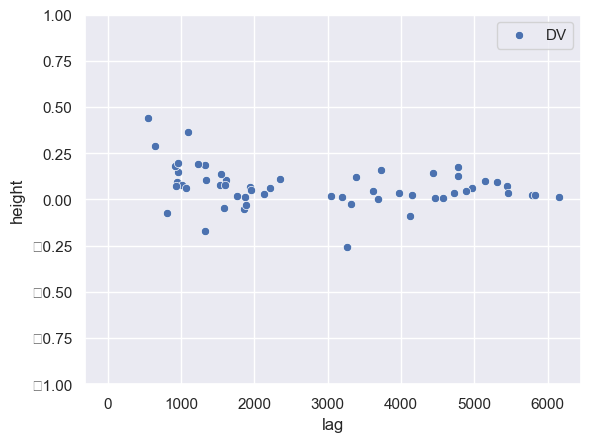

In [1105]:
sns.scatterplot(x=lag_DV,y=height_DV,label='DV')
#sns.scatterplot(x=lag_UV,y=height_UV,label='UV')
plt.ylim(-1,1)
plt.xlabel("lag")
plt.ylabel("height")
plt.show()

<Axes: ylabel='Count'>

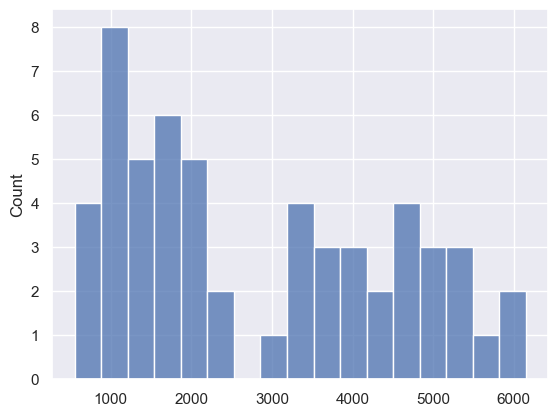

In [1131]:
sns.histplot([x for x in lag_DV if x>200],bins=17)

data_20240414_180023
[7145 7977]
0.08175484600480677
928


/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


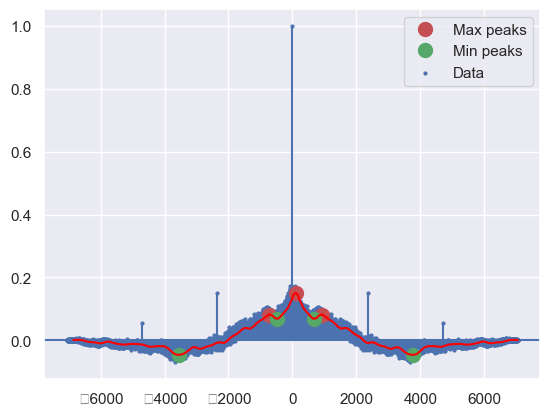

In [1080]:
number=24
print(UV_filename[number])
last_turn=np.concatenate([parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-3],
                            parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-2],
                            parse_and_plot_UV(UV_filename[number],UV_file_num[number])[3][:,-1]])

x,y,_,__=plt.acorr(last_turn,maxlags=len(last_turn)-1)

data=pd.DataFrame({"x":x,"y":y})
data["MA"]=data["y"].rolling(window=200).mean()

# 極大値と極小値を見つける
peaks_max, _ = find_peaks(data["MA"], prominence=0.01)  # prominenceはピークの高さのしきい値
peaks_min, _ = find_peaks(-1*data["MA"], prominence=0.01) # yを反転して極小値を見つけます
if len(np.where(x[peaks_max]>0)[0])>1:
    second_positive_index = np.where(x[peaks_max]>0)[0][1]
    print(peaks_max[np.where(x[peaks_max]>0)[0]])
    print(data["MA"][peaks_max[second_positive_index]])
    print(x[peaks_max[second_positive_index]])
else:
    print(-100)
    print(0)

plt.plot(x[peaks_max], data["MA"][peaks_max],'ro', label='Max peaks',markersize=10) # 極大値を赤でプロット
plt.plot(x[peaks_min], data["MA"][peaks_min],'go', label='Min peaks',markersize=10) # 極小値を緑でプロット
    
plt.scatter(x, y, label='Data',s=4)
plt.plot(x, data['MA'], color='red')
plt.legend()

# lag frequency

In [1135]:
index_DV_hf=[index for index, value in enumerate(lag_DV) if  2800>value >= 200]
index_DV_lf=[index for index, value in enumerate(lag_DV) if  2800<value]

In [1139]:
print(np.median([lag_DV[index] for index in index_DV_hf]))
print(np.max([lag_DV[index] for index in index_DV_hf]))
print(np.min([lag_DV[index] for index in index_DV_hf]))
print(np.median([lag_DV[index] for index in index_DV_lf]))
print(np.max([lag_DV[index] for index in index_DV_lf]))
print(np.min([lag_DV[index] for index in index_DV_lf]))

1339.0
2350
554
4516.5
6147
3040


In [1149]:
def parse_and_plot_filter_UV(filename,num):
    ampFault, recordtime = datfile(filename+'.dat')
    if recordtime==0:
        return
    if len(recordtime)==0:
        return
    #print(len(recordtime))
    #print(f'Selected time : {recordtime[num]}')

    def bunchindex(threshold,waveform):
        start=12800
        firstbunch=0
        for i in range(1,8*5120):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
        if firstbunch==0:
            print("invalid data")
            return firstbunch, 0
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(1700,ampFault[2][num])
    if firstbunch==0:
        print(f"end process: UV{filename}_{num}")
        return

    #print(f'Downstream Num of bunch : {len(bunch_index)}')
    #print(f'Downstream First bunch index : {firstbunch}')

    if firstbunch>140000:
        return

    start=12800
    y_pos=[]
    charge=[]
    for j in bunch_index:
        certain_bunch=[]
        certain_bunch_charge=[]
        for i in range(12):
            sum=ampFault[2][num][firstbunch+j*8+5120*8*i]
            delta=ampFault[3][num][firstbunch+j*8+5120*8*i]
            yposition=delta/sum*16.58/5+1.6
            certain_bunch.append(yposition)
            certain_bunch_charge.append(sum)
        y_pos.append(np.array(certain_bunch))
        charge.append(np.array(certain_bunch_charge))
    y_pos=np.array(y_pos)
    charge=np.array(charge)

    mean=np.mean(y_pos[:,0:2],axis=1)
    y_pos=y_pos-mean[:,np.newaxis]
    mean=np.mean(charge[:,0:2],axis=1)
    charge=charge/mean[:,np.newaxis]
    #print(y_pos[:,-3:])
    #print(charge)
    y_first_turn=np.concatenate(y_pos[:,3:5])
    y_last_turn=np.concatenate(y_pos[:,-3:])
    loss=1-np.min(np.concatenate(charge))
    
    #make x axis
    bunch_index_12=[]
    for i in range(12):
        bunch_index_12.append(bunch_index+5120*i)

    x_axis=np.concatenate(bunch_index_12)/5120+1
        
    split=np.hsplit(y_pos,y_pos.shape[1])
    pos=np.concatenate(split).flatten()
    data=pd.DataFrame({"x_axis":x_axis,"UV":pos})
    data["MA"]=data["UV"].rolling(window=500).mean()

    # サンプリング周波数
    fs = 1.0  # Hz
    # バンドパスフィルターの帯域
    lowcut = 0.0004  # Hz
    highcut = 0.0018  # Hz
    # フィルターオーダー（適宜調整）
    order = 100
    # FIRフィルターの設計
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b = firwin(order, [low, high], pass_zero=False)
    
    # バンドパスフィルターの適用
    filtered_data = lfilter(b, 1.0, data["UV"])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(23,8))
    ax1.set_title(f'{recordtime[num]}')
    ax1.scatter(data["x_axis"],data["UV"],color="tomato",s=5)
    ax1.plot(data["x_axis"],filtered_data,color='tab:green')
    ax1.set_ylabel("Y position (mm)")
    ax1.set_ylim(-0.4,0.4)
    ax1.grid()
    ax1.text(0.03,0.05,'Upstream Vertical',transform=ax1.transAxes,ha='left',va='bottom',fontsize=20)

    split=np.hsplit(charge,charge.shape[1])
    ax2.scatter(x_axis,np.concatenate(split),color='royalblue',s=6)
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Charge")
    ax2.set_ylim(0,1.2)
    ax2.grid()
    ax2.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13],['0','0','1','2','3','4','5','6','7','8','9','10','abort'])
    ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax2.set_xlim(3,13)
    ax2.text(0.03,0.05,'Upstream Charge',transform=ax2.transAxes,ha='left',va='bottom',fontsize=20)
    
    plt.subplots_adjust(hspace=.1)
    #plt.savefig('/home/nomaru/work/ipac_analysis/UV/'+filename[5:]+f'_{num}'+'.png',dpi=200,bbox_inches="tight",pad_inches=0.5)
    #plt.close()
    print("succeed")
    
    return np.std(y_last_turn)/np.std(y_first_turn), (np.max(y_last_turn)-np.min(y_last_turn))/(np.max(y_first_turn)-np.min(y_first_turn)), loss



In [1253]:
def parse_and_plot_filter_DV(filename,num,low,high,order):
    ampFault, recordtime = datfile(filename+'.dat')
    if recordtime==0:
        return
    if len(recordtime)==0:
        return
    #print(len(recordtime))
    #print(f'Selected time : {recordtime[num]}')

    def bunchindex(threshold,waveform):
        start=12800
        firstbunch=0
        for i in range(1,8*5120):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
        if firstbunch==0:
            print("invalid data")
            return firstbunch, 0
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(1000,ampFault[0][num])
    if firstbunch==0:
        print(f"end process: DV{filename}_{num}")
        return

    #print(f'Downstream Num of bunch : {len(bunch_index)}')
    #print(f'Downstream First bunch index : {firstbunch}')

    if firstbunch>140000:
        return

    start=12800
    y_pos=[]
    charge=[]
    for j in bunch_index:
        certain_bunch=[]
        certain_bunch_charge=[]
        for i in range(12):
            sum=ampFault[0][num][firstbunch+j*8+5120*8*i]
            delta=ampFault[1][num][firstbunch+j*8+5120*8*i]
            yposition=delta/sum*16.58/5+1.6
            certain_bunch.append(yposition)
            certain_bunch_charge.append(sum)
        y_pos.append(np.array(certain_bunch))
        charge.append(np.array(certain_bunch_charge))
    y_pos=np.array(y_pos)
    charge=np.array(charge)

    mean=np.mean(y_pos[:,0:2],axis=1)
    y_pos=y_pos-mean[:,np.newaxis]
    mean=np.mean(charge[:,0:2],axis=1)
    charge=charge/mean[:,np.newaxis]
    #print(y_pos[:,-3:])
    #print(charge)
    y_first_turn=np.concatenate(y_pos[:,3:5])
    y_last_turn=np.concatenate(y_pos[:,-3:])
    loss=1-np.min(np.concatenate(charge))
    
    #make x axis
    bunch_index_12=[]
    for i in range(12):
        bunch_index_12.append(bunch_index+5120*i)

    x_axis=np.concatenate(bunch_index_12)/5120+1
        
    split=np.hsplit(y_pos,y_pos.shape[1])
    pos=np.concatenate(split).flatten()
    data=pd.DataFrame({"x_axis":x_axis,"DV":pos})
    data["MA"]=data["DV"].rolling(window=500).mean()
    
    # サンプリング周波数
    fs = 1.0  # Hz
    # バンドパスフィルターの帯域
    lowcut = low  # Hz
    highcut = high  # Hz
   
    # FIRフィルターの設計
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b = firwin(order, [low, high], pass_zero=False)

    w, h = freqz(b, worN=8000)

    # 周波数をHzに変換
    freq = w * 0.5 * fs / np.pi
    """
    # プロット
    plt.figure(figsize=(10, 6))
    plt.plot(freq, 20 * np.log10(abs(h)), 'b')
    plt.title("Bandpass Filter Frequency Response")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Gain (dB)")
    plt.grid()
    plt.xlim(0,0.005)
    plt.ylim(-100,10)
    plt.show()
    """
    # バンドパスフィルターの適用
    filtered_data = lfilter(b, 1.0, data["DV"])

    sns.set(style='whitegrid')
    plt.style.use("default")
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(23,8))
    ax1.set_title(f'{recordtime[num]}')
    ax1.scatter(data["x_axis"],data["DV"],color="red",s=5)
    ax1.plot(data["x_axis"]-order/2/2346,filtered_data*5,color='tab:green',label='after BPF')
    ax1.set_ylabel("Y position (mm)")
    ax1.set_ylim(-0.4,0.4)
    ax1.grid()
    ax1.text(0.03,0.05,'Downstream Vertical',transform=ax1.transAxes,ha='left',va='bottom',fontsize=20)

    split=np.hsplit(charge,charge.shape[1])
    ax2.scatter(x_axis,np.concatenate(split),color='blue',s=6)
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Charge")
    ax2.set_ylim(0,1.2)
    ax2.grid()
    ax2.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13],['0','0','1','2','3','4','5','6','7','8','9','10','abort'])
    ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax2.set_xlim(3,13)
    ax2.text(0.03,0.05,'Downstream Charge',transform=ax2.transAxes,ha='left',va='bottom',fontsize=20)
    
    plt.subplots_adjust(hspace=.1)
    ax1.legend()
    plt.savefig('/home/nomaru/work/ipac_analysis/DV/'+filename[5:]+f'_{num}'+'.png',dpi=200,bbox_inches="tight",pad_inches=0.5)
    plt.close()
    #plt.show()
    print('succeed')
    
    return np.std(y_last_turn)/np.std(y_first_turn), (np.max(y_last_turn)-np.min(y_last_turn))/(np.max(y_first_turn)-np.min(y_first_turn)), loss,filtered_data

In [1248]:
for i in index_DV_hf:
    parse_and_plot_filter_DV(DV_filename[i],DV_file_num[i],0.0006,0.0017,3000)

succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed


In [1254]:
for i in index_DV_lf:
    parse_and_plot_filter_DV(DV_filename[i],DV_file_num[i],0.00018,0.00043,3000)

succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
